# Table of Content

01. Import Libraries
02. Import Data
03. Data Preprocessing
04. The Elbow Technique
05. Silhouette Analysis
06. Gap Statistic Method
07. K-Means Clustering
08. Visualizations and Basic Descriptive Statistics
09. Discussion

# 01. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler   # For data standardization
from sklearn.cluster import KMeans   # For K-Means clustering
from sklearn.metrics import silhouette_samples, silhouette_score   # For Silhouette analysis
from sklearn.metrics import pairwise_distances   # To calculate total within-cluster distance
import warnings

In [3]:
# Disable deprecation warnings that could indicate, for instance, a suspended library or feature. 
# These are more relevant to developers and very seldom to analysts.
warnings.filterwarnings('ignore')

In [5]:
# This option ensures the graphs you create are displayed in your notebook without the need to "call" them specifically.
%matplotlib inline

In [7]:
# Adjust setting to allow seeing all the rows in the output of this notebook
pd.options.display.max_rows = None

In [9]:
# Adjust setting to allow seeing all the columns in the output of this notebook
pd.options.display.max_columns = None

# 02. Import Data

In [11]:
# Import data
path = r'/Users/nhungphamthi/Documents/data analytis/Achievement 6'
df_gun_violence = pd.read_csv(os.path.join(path, 'cleaned_gunviolence.csv'), index_col = False)

In [13]:
df_gun_violence .head()

,Unnamed: 0,incident_id,date,state,n_killed,n_injured,n_guns_involved,n_victims,n_suspects,n_unharmed,n_arrested
0,0,461105,2013-01-01,Pennsylvania,0,4,0.0,4,1,0,1
1,1,460726,2013-01-01,California,1,3,0.0,4,1,0,0
2,2,478855,2013-01-01,Ohio,1,3,2.0,3,2,2,2
3,3,478925,2013-01-05,Colorado,4,0,0.0,3,1,0,0
4,4,478959,2013-01-07,North Carolina,2,2,2.0,3,1,0,0


In [15]:
df_gun_violence.shape

(239677, 11)

# 03. Data Preprocessing

### 03.1 Remove Categorical Variables

In [17]:
df_gun_violence .columns

Index(['Unnamed: 0', 'incident_id', 'date', 'state', 'n_killed', 'n_injured',
       'n_guns_involved', 'n_victims', 'n_suspects', 'n_unharmed',
       'n_arrested'],
      dtype='object')

In [53]:
# the date is string, so I seperate year and month and add more columns of year and month based on columns date.

df_gun_violence['Year']= df_gun_violence['date'].str[0:4]

df_gun_violence['Month']= df_gun_violence['date'].str[5:7]

df_gun_violence = df_gun_violence.astype({
    'Year': 'int64', 
    'Month': 'int64', 
    'n_killed': 'float64', 
    'n_injured': 'float64',
    'n_guns_involved': 'float64', 
    'n_victims': 'float64', 
    'n_suspects': 'float64',
    'n_unharmed': 'float64',
    'n_arrested': 'float64'})
    
df_gun_violence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239677 entries, 0 to 239676
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       239677 non-null  int64  
 1   incident_id      239677 non-null  int64  
 2   date             239677 non-null  object 
 3   state            239677 non-null  object 
 4   n_killed         239677 non-null  float64
 5   n_injured        239677 non-null  float64
 6   n_guns_involved  239677 non-null  float64
 7   n_victims        239677 non-null  float64
 8   n_suspects       239677 non-null  float64
 9   n_unharmed       239677 non-null  float64
 10  n_arrested       239677 non-null  float64
 11  Year             239677 non-null  int64  
 12  Month            239677 non-null  int64  
 13  clusters         239677 non-null  int32  
dtypes: float64(7), int32(1), int64(4), object(2)
memory usage: 24.7+ MB


In [21]:
df_include = ['n_killed', 'n_injured','n_guns_involved', 'n_victims', 'n_suspects', 'n_unharmed','n_arrested', 'Month', 'Year']
df_sub = df_gun_violence[df_include]

In [23]:
df_sub.shape

(239677, 9)

### 03.2 Standardization

In [25]:
# Define a standard scaler object
scaler = StandardScaler()
# Fit and transform data
df_sub_scaled = scaler.fit_transform(df_sub)

In [27]:
df_sub_scaled

array([[-0.48351913,  4.80305483, -0.22049462, ...,  0.71905166,
        -1.55230029, -2.21200776],
       [ 1.43300555,  3.4330994 , -0.22049462, ..., -0.50893204,
        -1.55230029, -2.21200776],
       [ 1.43300555,  3.4330994 ,  0.32870715, ...,  1.94703536,
        -1.55230029, -2.21200776],
       ...,
       [-0.48351913,  0.69318852,  0.05410626, ..., -0.50893204,
        -0.97219477,  1.86673626],
       [ 1.43300555, -0.67676691,  0.05410626, ..., -0.50893204,
        -0.97219477,  1.86673626],
       [ 3.34953023, -0.67676691,  0.32870715, ..., -0.50893204,
        -0.97219477,  1.86673626]])

# 04. Elbow Technique

In [29]:
# Define the range of potential clusters in the data.
num_cl = range(1, 42)
wcss = []

for i in num_cl: 
    # Define k-means clusters in the range assigned above.
    kmeans = KMeans(n_clusters = i)
    # Each k-means algorithm is applied onto data
    kmeans.fit(df_sub_scaled)
    # We access the inertia_ attribute of the fitted KMeans object, which contains the WCSS value
    wcss.append(kmeans.inertia_)
    
wcss

# The Within-Cluster Sum of Squares (WCSS) is the sum of the squared distances between each data point and its assigned centroid within the clusters. 
# It is a measure of the compactness of the clusters formed by the KMeans algorithm.
# The higher the number of clusters, the lower the value of WCSS.

[2157093.0000001616,
 1851759.3543435168,
 1683045.1415808173,
 1478184.9564127997,
 1389625.2905537034,
 1249039.661263775,
 1210260.0551368985,
 1152640.1424890542,
 1144440.2440817363,
 986637.3100975282,
 964359.1766061045,
 936027.1590782995,
 893281.0932573415,
 865829.1911806581,
 826174.9227870476,
 799933.9484717196,
 809349.9803707211,
 769492.6355848671,
 756990.0057460273,
 716163.1994100923,
 695878.3360766305,
 661783.0852570334,
 645921.7773818664,
 636126.8218240143,
 606682.0719762503,
 611422.6164678857,
 602423.737186688,
 576052.4548776906,
 567636.3322970462,
 571576.5725181221,
 560275.6683563343,
 537447.9920181626,
 551619.0981362902,
 527285.4419163844,
 508448.3336959691,
 493663.02097974747,
 492052.1296937284,
 474547.52498079505,
 481765.72364049964,
 466482.42734604934,
 458989.69476890133]

In [31]:
plt.plot(num_cl, wcss)
plt.title('Elbow Curve')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

Text(0, 0.5, 'WCSS')

Interpretation:
From the elbow curve, it is inconclusive to determine the optimal number of clusters as there is no obvious elbow from the curve. <br> So I try with Silhouette analysis. 

# 05. Silhouette Analysis

In [38]:
# Define the range of number of clusters to evaluate
num_clusters = 3  # Choose the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(df_sub_scaled)

In [ ]:
# Calculate Silhouette Scores
silhouette_avg = silhouette_score(df_sub_scaled, cluster_labels)
sample_silhouette_values = silhouette_samples(df_sub_scaled, cluster_labels)
print(f'Average Silhouette Score: {silhouette_avg}')

<b>Interpretation: </b><br>
Silhoutte analysis takes too long to run on whole dataset. I couldnt run it even I tried again and again many times.

# 06. Gap Statistic Method

Optimal number of clusters: 1


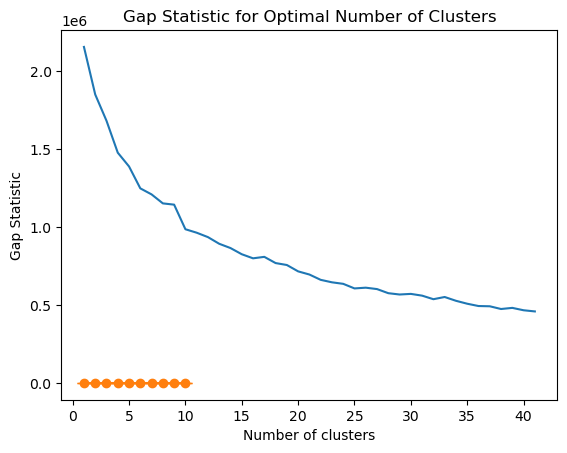

In [35]:
def generate_reference_data(data, n_refs):
    """
    Generate reference datasets by uniformly sampling within the bounds of the original dataset.
    
    Parameters:
    - data: numpy.ndarray, the original dataset
    - n_refs: int, number of reference datasets to generate
    
    Returns:
    - rands: numpy.ndarray, array containing the reference datasets
    """
    shape = data.shape
    tops = data.max(axis=0)  # Maximum value for each feature
    bots = data.min(axis=0)  # Minimum value for each feature
    
    # Generate uniformly distributed random points within the data bounds
    rands = np.random.random_sample(size=(shape[0], shape[1], n_refs))
    for i in range(n_refs):
        rands[:, :, i] = rands[:, :, i] * (tops - bots) + bots   # Scale and shift the random points to match the data's range

    return rands

def gap_statistic(data, n_refs=20, max_k=10):   # These are default values set, can be overwritten when calling the function
    """
    Compute the Gap Statistic for an input dataset and a range of cluster counts.
    
    Parameters:
    - data: numpy.ndarray, the dataset to be clustered
    - n_refs: int, number of reference datasets to generate
    - max_k: int, the maximum number of clusters to test
    
    Returns:
    - gaps: numpy.ndarray, the Gap values for each k
    - s_k: numpy.ndarray, the standard deviations for each k
    - optimal_k: int, the estimated optimal number of clusters
    """
    # Generate reference datasets
    rands = generate_reference_data(data, n_refs)
    
    # Initialize arrays to hold Gap values, standard deviations, and log within-cluster dispersions
    gaps = np.zeros(max_k)
    s_k = np.zeros(max_k)
    log_Wk = np.zeros(max_k)
    log_Wk_ref = np.zeros((max_k, n_refs))

    # Loop over each k (number of clusters) to compute the Gap Statistic
    for k in range(1, max_k + 1):
        # Fit KMeans to the original data and compute within-cluster dispersion Wk using pairwise distances
        kmeans = KMeans(n_clusters=k).fit(data)
        Wk = sum(np.min(pairwise_distances(data, kmeans.cluster_centers_), axis=1))
        log_Wk[k - 1] = np.log(Wk)   # Log-transform the within-cluster dispersion

        # Fit KMeans to the reference datasets and compute within-cluster dispersion Wk_ref using pairwise distances
        for i in range(n_refs):
            kmeans_ref = KMeans(n_clusters=k).fit(rands[:, :, i])
            Wk_ref = sum(np.min(pairwise_distances(rands[:, :, i], kmeans_ref.cluster_centers_), axis=1))
            log_Wk_ref[k - 1, i] = np.log(Wk_ref)   # Log-transform the within-cluster dispersion for the reference data

        # Calculate the Gap statistic
        gaps[k - 1] = np.mean(log_Wk_ref[k - 1, :]) - log_Wk[k - 1]   # Gap = mean(log(Wk*)) - log(Wk)
        s_k[k - 1] = np.std(log_Wk_ref[k - 1, :])   # Standard deviation of log(Wk*) for error bars

    # Determine the optimal number of clusters
    optimal_k = np.argmax(gaps) + 1   # Start with the k that has the maximum gap
    for k in range(1, max_k):
        if gaps[k - 1] >= gaps[k] - s_k[k]:
            optimal_k = k
            break

    return gaps, s_k, optimal_k

# Execute the functions above
data = df_sub_scaled

# Compute the Gap Statistic with 10 reference datasets
gaps, s_k, optimal_k = gap_statistic(data, n_refs=10, max_k=10)

# Print the optimal number of clusters
print(f'Optimal number of clusters: {optimal_k}')

# Plot the Gap Statistic with error bars
plt.errorbar(range(1, 11), gaps, yerr=s_k, fmt='-o', capsize=5)
plt.xlabel('Number of clusters')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic for Optimal Number of Clusters')
plt.show()

In [37]:
gaps

array([3.25984344, 3.21604964, 3.23232522, 3.26378698, 3.24583822,
       3.24625426, 3.2914488 , 3.27169518, 3.28583942, 3.27181771])

In [39]:
s_k

array([0.00054643, 0.00847924, 0.00053446, 0.00451523, 0.00041723,
       0.00230259, 0.00442446, 0.00352668, 0.00274317, 0.00134891])

The dataset is likely not naturally separable into clusters.
The data points may be uniformly distributed rather than forming distinct groups.
Applying clustering (like K-Means) may not be useful.

# 07. K-Means Clustering

In [43]:
# Create the k-means object with the optimal number of clusters.
kmeans = KMeans(n_clusters = 2)

In [45]:
# Fit the k-means object to the data.
kmeans.fit(df_sub_scaled)

KMeans(n_clusters=2)

In [55]:
# Create a column in the dataframe with values corresponding to which cluster every observation belongs.
df_gun_violence['clusters'] = kmeans.labels_

In [57]:
df_gun_violence.head()

,Unnamed: 0,incident_id,date,state,n_killed,n_injured,n_guns_involved,n_victims,n_suspects,n_unharmed,n_arrested,Year,Month,clusters
0,0,461105,2013-01-01,Pennsylvania,0.0,4.0,0.0,4.0,1.0,0.0,1.0,2013,1,0
1,1,460726,2013-01-01,California,1.0,3.0,0.0,4.0,1.0,0.0,0.0,2013,1,0
2,2,478855,2013-01-01,Ohio,1.0,3.0,2.0,3.0,2.0,2.0,2.0,2013,1,1
3,3,478925,2013-01-05,Colorado,4.0,0.0,0.0,3.0,1.0,0.0,0.0,2013,1,0
4,4,478959,2013-01-07,North Carolina,2.0,2.0,2.0,3.0,1.0,0.0,0.0,2013,1,0


In [59]:
df_gun_violence['clusters'].value_counts(dropna = False)

clusters
0    141686
1     97991
Name: count, dtype: int64

# 08. Visualizations and Basic Descriptive Statistics

<Figure size 900x600 with 0 Axes>

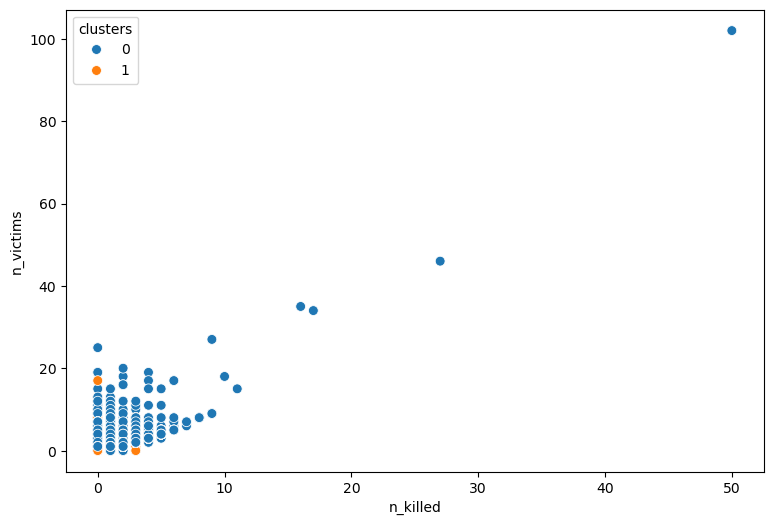

In [63]:
# Plot the clusters for the "n_killed" and "n_victims" variables.

plt.figure(figsize = (9, 6))
ax = sns.scatterplot(x = df_gun_violence['n_killed'], y = df_gun_violence['n_victims'], 
                     hue = df_gun_violence['clusters'], s = 50) 
# 's' represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('n_killed') # Label x-axis.
plt.ylabel('n_victims') # Label y-axis.
plt.show()

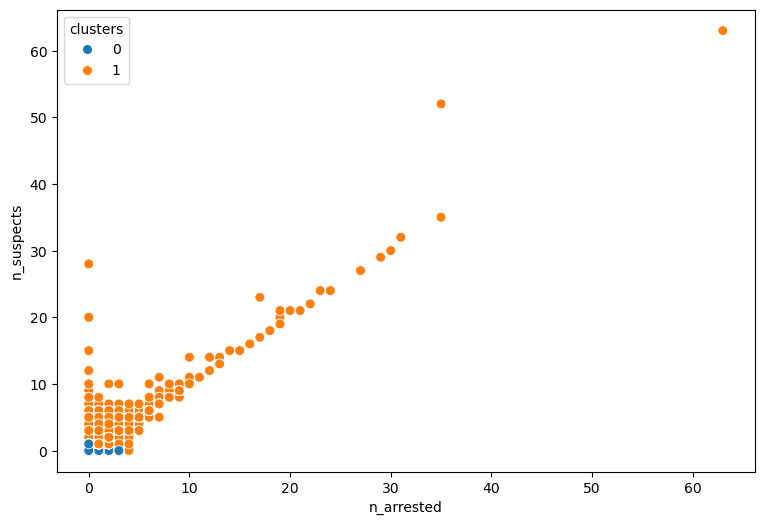

In [65]:
# Plot the clusters for the "n_arrested" and "n_suspects" variables.

plt.figure(figsize = (9, 6))
ax = sns.scatterplot(x = df_gun_violence['n_arrested'], y = df_gun_violence['n_suspects'], 
                     hue = df_gun_violence['clusters'], s = 50) 
# 's' represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('n_arrested') # Label x-axis.
plt.ylabel('n_suspects') # Label y-axis.
plt.show()

In [67]:
df_gun_violence.loc[df_gun_violence['clusters'] == 0, 'cluster'] = 'blue'
df_gun_violence.loc[df_gun_violence['clusters'] == 1, 'cluster'] = 'orange'

In [71]:
# Basic descriptive statistics for each cluster
df_gun_violence.groupby('cluster').agg({'n_killed':['mean', 'median'], 
                                    'n_victims':['mean', 'median'], 
                                    'n_suspects':['mean', 'median'],
                                    'n_arrested':['mean', 'median']})

n_killed        n_victims        n_suspects        n_arrested       
             mean median      mean median       mean median       mean median
cluster                                                                      
blue     0.324372    0.0  0.977662    1.0   0.331564    0.0   0.053343    0.0
orange   0.148065    0.0  0.556572    0.0   1.554071    1.0   0.936566    1.0

Interpretion
1. Blue Cluster

Lower number of suspects (0.33 on average, median = 0)
Fewer arrests (mean = 0.053, median = 0)
Higher victim count than the orange cluster (mean = 0.98, median = 1)
Higher deaths compared to orange (mean = 0.324, median = 0)
This might represent incidents with fewer suspects and arrests but more casualties.

2. Orange Cluster

Higher number of suspects (1.55 mean, median = 1)
More arrests (0.94 mean, median = 1)
Fewer victims on average (0.56 mean, median = 0)
Lower deaths than the blue cluster (0.148 mean, median = 0)
This might represent incidents where more suspects are involved, leading to more arrests but fewer casualties.

# 09. Discussion

From the previous exploratory visual analysis, we have hypotheses as below: 

The blue cluster might represent deadlier incidents with fewer suspects and arrests (e.g., lone shooters or single-perpetrator crimes).

The orange cluster has more suspects and arrests, suggesting group crimes or gang-related violence, but with fewer fatalities.